In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from torch import nn
import torch.utils.data as data
from torchvision import transforms
from random import sample
from PIL import Image, ImageFile
import os
from tqdm import tqdm
import torch.nn.functional as F
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
from google.colab.patches import cv2_imshow

from torch.utils.data import DataLoader
from torch.autograd import Variable
from torch import nn
import torch
import os
import logging
import numpy as np
import math

In [ ]:
!nvidia-smi

Wed May  3 20:52:25 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   54C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
root = '/content/drive/MyDrive/CS4644_project/data/train'
test_path = '/content/drive/MyDrive/CS4644_project/data/test'
batchsize = 8
model_path =  '/content/drive/MyDrive/CS4644_project/model'
output_path = '/content/drive/MyDrive/CS4644_project/model'

In [ ]:
# class DnCNN(nn.Module):
#     def __init__(self, channels = 3, num_of_layers = 7):
#         super(DnCNN, self).__init__()
#         kernel_size = 3
#         padding = 1
#         features = 64
#         layers = []
#         layers.append(nn.Conv2d(in_channels=channels, out_channels=features, kernel_size=kernel_size, padding=padding, bias=False))
#         layers.append(nn.ReLU(inplace=True))
#         for _ in range(num_of_layers-2):
#             layers.append(nn.Conv2d(in_channels=features, out_channels=features, kernel_size=kernel_size, padding=padding, bias=False))
#             layers.append(nn.BatchNorm2d(features))
#             layers.append(nn.ReLU(inplace=True))
#         layers.append(nn.Conv2d(in_channels=features, out_channels=channels, kernel_size=kernel_size, padding=padding, bias=False))
#         self.dncnn = nn.Sequential(*layers)
#     def forward(self, x):
#         out = self.dncnn(x)
#         return out

In [ ]:
class DnCNN(nn.Module):
    def __init__(self, channels = 3, num_of_layers = 6):
        super(DnCNN, self).__init__()
        kernel_size = 3
        padding = 1
        features = 64
        layers = []
        layers.append(nn.Conv2d(in_channels=channels, out_channels=features, kernel_size=kernel_size, padding=padding, bias=False))
        layers.append(nn.ReLU(inplace=True))
        for _ in range(num_of_layers-5):
            layers.append(nn.Conv2d(in_channels=features, out_channels=features, kernel_size=kernel_size, padding=padding, bias=False))
            layers.append(nn.BatchNorm2d(features))
            layers.append(nn.ReLU(inplace=True))
        layers.append(nn.Conv2d(in_channels=64, out_channels=128, kernel_size=kernel_size, stride = 2, padding=padding, bias=False))
        layers.append(nn.BatchNorm2d(128))
        layers.append(nn.ReLU(inplace=True))
        layers.append(nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True))
        layers.append(nn.Conv2d(in_channels=128, out_channels=64, kernel_size=kernel_size, padding=padding, bias=False))
        layers.append(nn.BatchNorm2d(64))
        layers.append(nn.ReLU(inplace=True))
        for _ in range(1):
            layers.append(nn.Conv2d(in_channels=features, out_channels=features, kernel_size=kernel_size, padding=padding, bias=False))
            layers.append(nn.BatchNorm2d(features))
            layers.append(nn.ReLU(inplace=True))
        layers.append(nn.Conv2d(in_channels=features, out_channels=channels, kernel_size=kernel_size, padding=padding, bias=False))
        self.dncnn = nn.Sequential(*layers)
    def forward(self, x):
        out = self.dncnn(x)
        return out

In [ ]:
class LambdaLayer(nn.Module):

    def __init__(self, lambd):
        super(LambdaLayer, self).__init__()
        self.lambd = lambd

    def forward(self, x):
        return self.lambd(x)

class Block(nn.Module):
    
    def __init__(self, in_channels, out_channels, stride=1):
        super(Block, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.lbd = None
        if stride != 1 or in_channels != out_channels:
            self.lbd = LambdaLayer(lambda x: nn.functional.pad(x[:, :, ::2, ::2], (0, 0, 0, 0, out_channels//4, out_channels//4), "constant", 0))
        
    def forward(self, x):
        identity = x
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        if self.lbd is not None:
            identity = self.lbd(identity)
        x += identity
        x = self.relu(x)
        return x

class MRNet(nn.Module):
    # You can use pre-existing models but change layers to recieve full credit.
    def __init__(self):
        super(MRNet, self).__init__()
        # (N, C, H, W) = (_, 3, 512, 512)
        self.in_channels = 3
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        #  (N, C, H, W) = (_, 32, 512, 512)
        self.bn1 = nn.BatchNorm2d(32)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(2, 2)
        # (N, C, H, W) = (_, 32, 256, 256)
        self.layer1 = self.layer(32, 64, stride=2)
        # (N, C, H, W) = (_, 64, 128, 128)
        self.layer2 = self.layer(64, 64, stride=1)
        self.upsampling1 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        # (N, C, H, W) = (_, 64, 256, 256)
        self.layer3 = self.layer(64, 64, stride=1)
        # (N, C, H, W) = (_, 64, 256, 256)
        self.upsampling2 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        # (N, C, H, W) = (_, 64, 512, 512)
        lastLayer = []
        lastLayer.append(nn.Conv2d(64, 32, kernel_size=3, stride=1, padding=1))
        lastLayer.append(nn.BatchNorm2d(32))
        lastLayer.append(nn.ReLU(inplace=True))
        lastLayer.append(nn.Conv2d(32, 3, kernel_size=3, stride=1, padding=1))
        self.layer4 = nn.Sequential(*lastLayer)
        # (N, C, H, W) = (_, 3, 512, 512)
    
    def layer(self, in_channels, out_channels, stride):
        return nn.Sequential(Block(in_channels, out_channels, stride=stride), Block(out_channels, out_channels))
    
    def forward(self, x):
        outs = self.conv1(x)
        outs = self.bn1(outs)
        outs = self.relu(outs)
        outs = self.maxpool(outs)
        outs = self.layer1(outs)
        outs = self.layer2(outs)
        outs = self.upsampling1(outs)
        outs = self.layer3(outs)
        
        outs = self.upsampling2(outs)
        outs = self.layer4(outs)

        return outs

In [ ]:
class MoirePic(data.Dataset):
    def __init__(self, rootX, rootY, training=True):
        self.picX = [os.path.join(rootX, img) for img in os.listdir(rootX)]
        self.picY = [os.path.join(rootY, img) for img in os.listdir(rootY)]
        self.picX.sort()
        self.picY.sort()
        self.pics = list(zip(self.picX, self.picY))
        # self.pics = self.pics[:400]
        self.Len = len(self.pics)

        if not training:
            self.pics = sample(self.pics, self.Len // 10)
            self.Len = len(self.pics)

    def __getitem__(self, index):
        tf = transforms.Compose([
            #transforms.CenterCrop(256),
            transforms.ToTensor()
        ])

        path_pair = self.pics[index]
        imgX, imgY = Image.open(path_pair[0]), Image.open(path_pair[1])
        return tf(imgX), tf(imgY)

    def __len__(self):
        return self.Len


def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(mean=0.0, std=0.01)
        m.bias.data.fill_(0)


if __name__=='__main__':
    # you need to clean the training set
    input_path = os.path.join(root, 'input_train')
    gt_path = os.path.join(root, 'gt_train')
    input_imgs = [os.path.join(input_path, img) for img in os.listdir(input_path)]
    gt_imgs = [os.path.join(gt_path, img) for img in os.listdir(gt_path)]
    print(len(input_imgs))
    print(len(gt_imgs))
    input_imgs.sort()
    gt_imgs.sort()
    

    cot = 0
    loop = tqdm(enumerate(input_imgs), total=len(input_imgs), leave=False)
    print(len(loop))
    for idx, img in loop:
        with open(img, "rb") as f:
            ImPar=ImageFile.Parser()
            chunk = f.read(2048)
            count=2048
            while chunk != "":
                ImPar.feed(chunk)
                if ImPar.image:
                    break
                chunk = f.read(2048)
                count+=2048
            M, N = ImPar.image.size[0], ImPar.image.size[1]

        if M < 512 or N < 512:
            os.remove(input_imgs[idx])
            print(idx)
            os.remove(gt_imgs[idx])
            cot += 1
        
        loop.set_postfix(unfit_imgs=cot)

    print("Done! Get %d unfit images." % cot)

1082
1082


  0%|          | 0/1082 [00:00<?, ?it/s]

1082


Done! Get 0 unfit images.


In [ ]:
torch.cuda.set_device(0)

def train(model, train_loader, criterion, epoch, lr, use_gpu):
    model.train()

    # loop = tqdm(enumerate(train_loader), total=len(train_loader), leave=False)
    for batch_idx, (data, target) in enumerate(train_loader):
        if use_gpu:
            data, target = data.cuda(
                non_blocking=True), target.cuda(non_blocking=True)
        data, target = Variable(data), Variable(target)

        optimizer = torch.optim.Adam(
            model.parameters(), lr=lr, weight_decay=0.00001)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        # loop.set_description(f'Train Epoch [{epoch}/50]')
        # loop.set_postfix(loss = loss.item())
        if batch_idx % 10 == 0:
            logging.info('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.data))
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.data))

def val(model, val_loader, epoch, use_gpu):
    model.eval()

    idx, loss_sum = 0, 0.0
    criterion = nn.MSELoss()

    for (data, target) in val_loader:
        if use_gpu:
            data, target = data.cuda(
                non_blocking=True), target.cuda(non_blocking=True)
        data, target = Variable(data), Variable(target)

        with torch.no_grad():
            output = model(data)
            loss = criterion(output, target)

        loss_sum += loss.item()
        idx += 1
    loss_sum /= idx

    logging.info('Val Epoch: {} \tLoss: {:.6f}'.format(
        epoch, loss_sum))

    return loss_sum

In [ ]:
def weights_init_kaiming(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.kaiming_normal(m.weight.data, a=0, mode='fan_in')
    elif classname.find('Linear') != -1:
        nn.init.kaiming_normal(m.weight.data, a=0, mode='fan_in')
    elif classname.find('BatchNorm') != -1:
        # nn.init.uniform(m.weight.data, 1.0, 0.02)
        m.weight.data.normal_(mean=0, std=math.sqrt(2./9./64.)).clamp_(-0.025,0.025)
        nn.init.constant(m.bias.data, 0.0)

In [ ]:
import tensorflow as tf

dataset = MoirePic(os.path.join(root, 'input_train'),
                    os.path.join(root, 'gt_train'))
valdataset = MoirePic(os.path.join(test_path, 'input_test'),
                        os.path.join(test_path, 'gt_test'), False)

use_gpu = torch.cuda.is_available()
train_loader = DataLoader(dataset=dataset, shuffle=True, batch_size= batchsize,
                            num_workers=14, pin_memory=True)
val_loader = DataLoader(dataset=valdataset, shuffle=True, batch_size=batchsize,
                        num_workers=14, pin_memory=True)
logging.info('loaded dataset successfully!')
logging.info(f'the number of training set images: {dataset.__len__()}')

# model = DnCNN()
# model.apply(weights_init_kaiming)

model = MRNet()
# model = torch.load("moire_best.pth")
print(model)

if use_gpu:
    model = model.cuda()
    # model = nn.DataParallel(model)
    logging.info('use GPU')
else:
    print('use CPU')

criterion = nn.MSELoss()
lr = 0.0001
best_loss, last_loss = 100.0, 100.0

logging.info(f'learning rate: {lr}, batch size: {batchsize}')


In [ ]:
import copy
val_loss = []
best_model = None

for epoch in range(25):
    train(model, train_loader, criterion, epoch, lr, use_gpu)
    current_loss = val(model, val_loader, epoch, use_gpu)
    val_loss.append(current_loss)
    
    if current_loss < best_loss:
        best_loss = current_loss
        #torch.save(model, os.path.join(output_path, 'resnet_moire_best.pth'))
        best_model = copy.deepcopy(model)
        torch.save(model.state_dict(), os.path.join(output_path, 'mrnet_moire_best.pth'))
    if current_loss > last_loss:
        lr *= 0.9

    last_loss = current_loss

In [ ]:
def gaussian(window_size, sigma):
    """
    Generates a list of Tensor values drawn from a gaussian distribution with standard
    diviation = sigma and sum of all elements = 1.

    Length of list = window_size
    """    
    gauss =  torch.Tensor([math.exp(-(x - window_size//2)**2/float(2*sigma**2)) for x in range(window_size)])
    return gauss/gauss.sum()

def create_window(window_size, channel=1):

    # Generate an 1D tensor containing values sampled from a gaussian distribution
    _1d_window = gaussian(window_size=window_size, sigma=1.5).unsqueeze(1)
    
    # Converting to 2D  
    _2d_window = _1d_window.mm(_1d_window.t()).float().unsqueeze(0).unsqueeze(0)
     
    window = torch.Tensor(_2d_window.expand(channel, 1, window_size, window_size).contiguous())

    return window

# helper function to load images
load_images = lambda x: np.asarray(Image.open(x).resize((480, 640)))

# Helper functions to convert to Tensors
tensorify = lambda x: torch.Tensor(x.transpose((2, 0, 1))).unsqueeze(0).float().div(255.0)

# display imgs 
def display_imgs(x, transpose=True, resize=True):
  if resize:
    x=cv2.resize(x, (400, 400))
  if transpose:
    cv2_imshow(cv2.cvtColor(x, cv2.COLOR_BGR2RGB))
  else:
    cv2_imshow(x)

In [ ]:
def ssim(img1, img2, val_range, window_size=11, window=None, size_average=True, full=False):

    L = val_range # L is the dynamic range of the pixel values (255 for 8-bit grayscale images),

    pad = window_size // 2
    
    try:
        _, channels, height, width = img1.size()
    except:
        channels, height, width = img1.size()

    # if window is not provided, init one
    if window is None: 
        real_size = min(window_size, height, width) # window should be atleast 11x11 
        window = create_window(real_size, channel=channels).to(img1.device)
    
    # calculating the mu parameter (locally) for both images using a gaussian filter 
    # calculates the luminosity params
    mu1 = F.conv2d(img1, window, padding=pad, groups=channels)
    mu2 = F.conv2d(img2, window, padding=pad, groups=channels)
    
    mu1_sq = mu1 ** 2
    mu2_sq = mu2 ** 2 
    mu12 = mu1 * mu2

    # now we calculate the sigma square parameter
    # Sigma deals with the contrast component 
    sigma1_sq = F.conv2d(img1 * img1, window, padding=pad, groups=channels) - mu1_sq
    sigma2_sq = F.conv2d(img2 * img2, window, padding=pad, groups=channels) - mu2_sq
    sigma12 =  F.conv2d(img1 * img2, window, padding=pad, groups=channels) - mu12

    # Some constants for stability 
    C1 = (0.01 ) ** 2  # NOTE: Removed L from here (ref PT implementation)
    C2 = (0.03 ) ** 2 

    contrast_metric = (2.0 * sigma12 + C2) / (sigma1_sq + sigma2_sq + C2)
    contrast_metric = torch.mean(contrast_metric)

    numerator1 = 2 * mu12 + C1  
    numerator2 = 2 * sigma12 + C2
    denominator1 = mu1_sq + mu2_sq + C1 
    denominator2 = sigma1_sq + sigma2_sq + C2

    ssim_score = (numerator1 * numerator2) / (denominator1 * denominator2)

    if size_average:
        ret = ssim_score.mean() 
    else: 
        ret = ssim_score.mean(1).mean(1).mean(1)
    
    if full:
        return ret, contrast_metric
    
    return ret

  0%|          | 0/39 [00:00<?, ?it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


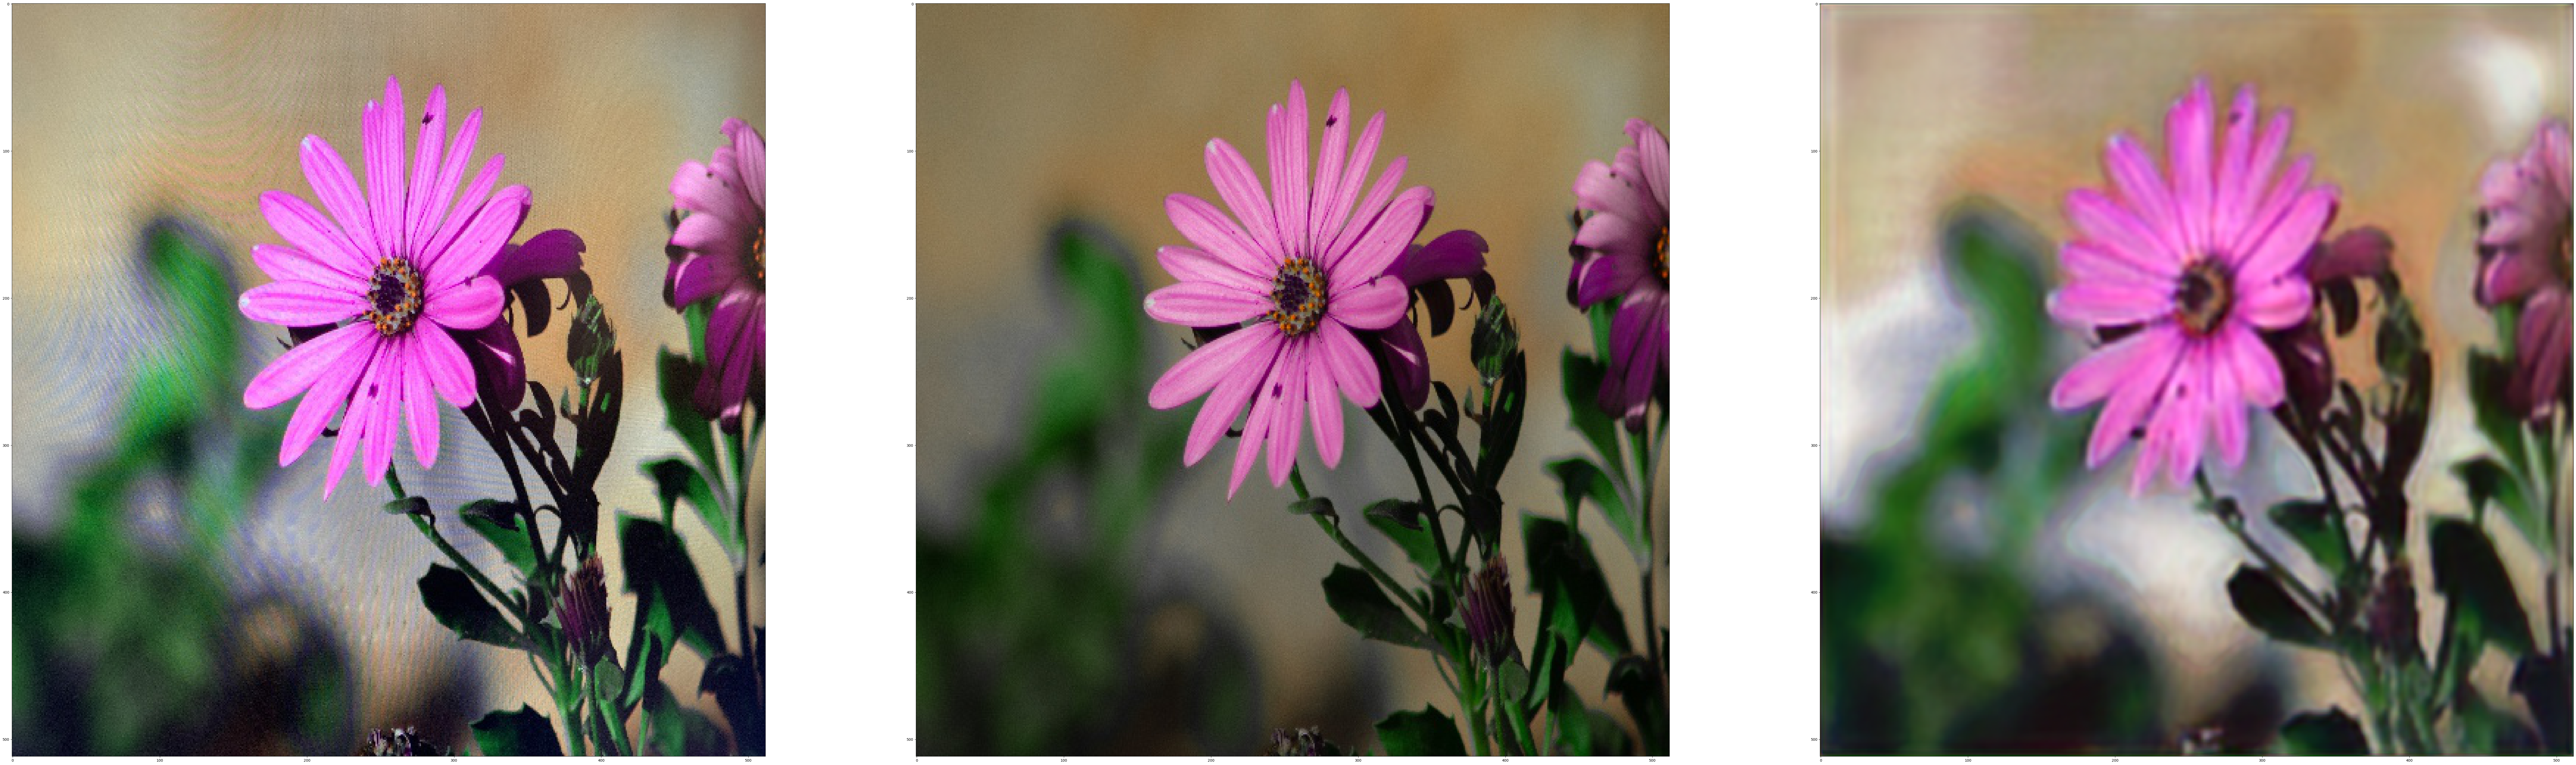


testing dataset SSIM: 0.9994515776634216
testing dataset PSNR: 17.318475090541394


In [ ]:
def psnr(img1, img2):
    mse = np.mean((img1 - img2) ** 2)
    if mse == 0:
        return 100
    return 10 * math.log10(1 / mse)

dataset = MoirePic(os.path.join(test_path, 'input_test'),
                    os.path.join(test_path, 'gt_test'))
test_loader = DataLoader(dataset=dataset, batch_size=4, drop_last=False)
# you can change batchsize to get a faster speed
#model = torch.load('/content/drive/MyDrive/CS4644_project/model/mrnet_moire_best.pth')
# model = MRNet()
# model.load_state_dict(torch.load('/content/drive/MyDrive/CS4644_project/model/mrnet_moire_best.pth'))
model = best_model
model.eval()

psnr_all, count = 0.0, 0
loop = tqdm(enumerate(test_loader), total=len(test_loader), leave=False)
ssim_vals = []

for idx, (data, target) in loop:
    data, target = data.cuda(), target.numpy()

    with torch.no_grad():
        output = model(data).cpu().numpy()
    if (idx == 0):
      orig = data.cpu().numpy()
      fig, (ax1,ax2,ax3) = plt.subplots(1, 3, figsize=(128, 128))
      img_pred = np.transpose(output[2],(1,2,0))
      img_gt = np.transpose(target[2],(1,2,0))
      img_orig = np.transpose(orig[2], (1,2,0))
      ax1.imshow(img_orig)
      ax2.imshow(img_gt)
      ax3.imshow(img_pred)
      plt.show()
    
    for i in range(target.shape[0]):
        psnr_all += psnr(output[i], target[i])
        img1 = tensorify(output[i])
        img2 = tensorify(target[i])
        ssim_val = ssim(img1, img2, val_range=255)
        ssim_vals.append(ssim_val)

    count += target.shape[0]
    loop.set_postfix(average_psnr=psnr_all / count)

average_ssim = sum(ssim_vals) / len(ssim_vals)

print('')
print(f'testing dataset SSIM: {average_ssim}')
print(f'testing dataset PSNR: {psnr_all / count}')

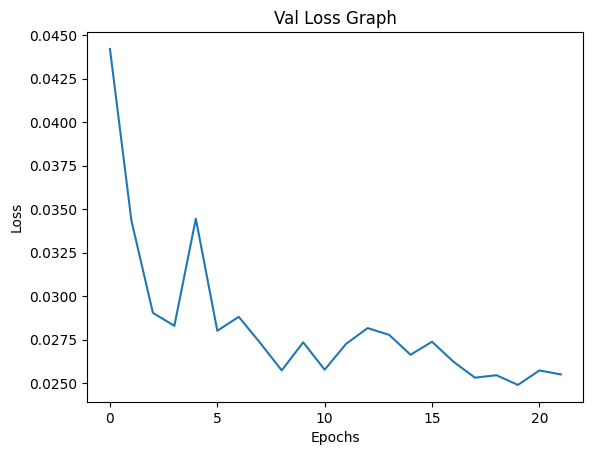

In [ ]:
epochs = np.arange(0, len(val_loss), 1, dtype=int)
plt.plot(epochs, val_loss)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Val Loss Graph")
plt.show()